In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
from matplotlib import colors

if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/"
path_figure4 = path_manustript + "Figure4/"
from pyMFI import MFI1D

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

grid_list = [np.linspace(0, 275, 2201), np.linspace(0, 310, 2481), np.linspace(0, 315, 2521), np.linspace(0, 330, 2641)]

def remove_flat_tail(x, FES, sd):
    
    while FES[-1] - FES[-3] < 10E-10:
        FES = FES[:-2]
        x = x[:-2]
        sd = sd[:-2]
        
    return [x, FES, sd]

The path is: /home/ucecabj/Desktop/MFI_git


In [3]:
def bootstrap_forw_back(grid, forward_force, backward_force, n_bootstrap, set_fes_minima=None):
    """Algorithm to determine bootstrap error

    Args:
        grid (array of shape (nbins,)): CV grid positions
        forward_force (list): collection of force terms (n * [Ftot_den, Ftot]) from forward transition
        backward_force (list): collection of force terms (n * [Ftot_den, Ftot]) from backward transition
        n_bootstrap (int): bootstrap iterations

    Returns:
        FES_avr (array of shape (nbins,)): Average of all FES generated during the bootstrap algorithm.
        sd_fes (array of shape (nbins,)): Standard deviation of all FES generated during the bootstrap algorithm.
        sd_fes_prog (array of shape (n_bootstrap,)): Global average of the standard deviation after each bootstrap iteration. When this array converges, enough iterations have been performed. If it does not converge, move iterations are necessary.
    """

    #Define constants and lists
    nbins = len(grid)
    n_forces = len(forward_force)
    sd_fes_prog = np.zeros(n_bootstrap)    
    FES_avr = np.zeros(nbins)
    M2 = np.zeros(nbins)
    
    FES_collection = []

    #Patch forces
    [Ftot_den, Ftot] = MFI1D.patch_forces(np.concatenate((forward_force, backward_force)))        

    for iteration in range(n_bootstrap):

        #Randomly choose forward forces and backward forces and save to force array
        force = np.zeros((int(n_forces * 2), 2, nbins)) 
        random_sample_index =  np.random.choice(n_forces-1, size=(2, n_forces))
        force[:n_forces] = forward_force[random_sample_index[0]]
        force[n_forces:] = backward_force[random_sample_index[1]]
                
        #patch forces to find average Ftot_den, Ftot and FES
        [Ftot_den, Ftot] = MFI1D.patch_forces(force)
        FES = MFI1D.intg_1D(Ftot, grid[1]-grid[0])
        FES = FES - FES[0]
        FES_collection.append(FES)

        # calculate standard devaition using Welford’s method
        delta = FES - FES_avr
        FES_avr += delta/(iteration+1)
        delta2 = FES - FES_avr
        M2 += delta*delta2
        sd_fes = np.sqrt(M2 / (iteration))
        sd_fes_prog[iteration] = sum(sd_fes)/nbins
        

        # print progress
        if (iteration+1) % 50 == 0: print("Iteration:", iteration+1, "- sd:", round(sd_fes_prog[iteration],5) )
        
    numpy_var = np.sqrt(np.var(FES_collection, axis=0))
    
    plt.plot(grid, numpy_var)
    plt.plot(grid, sd_fes)
    plt.show()
       
    return [FES_avr, sd_fes, sd_fes_prog]

# [forceterms_forw, forceterms_back] = MFI1D.load_npy(path_figure4 + "LJ_n" + name_list[i] + "_allforces")
# [FES_avr, sd_fes, sd_fes_prog ] = bootstrap_forw_back(grid_list[i], np.asarray(forceterms_forw[:,[0,2],:]), np.asarray(forceterms_back[:,[0,2],:]), n_bootstrap=n_bootstrap, set_fes_minima="first_value")


#### Load T6n55 dataset forces

In [4]:
path_master = "/home/ucecabj/Storage/MFI_new/LJ_fluid/LJ_results23/results_T6n55/"

#initialise force list and grid
forceterms_forw = []; forceterms_back = []

index_list = np.arange(1,51).tolist()
index_list.remove(9)

# #shuffel up indexes
# a = []
# intv = 16
# for j in range(intv):
#     for i in index_list[j::intv]: a.append(i)
# index_list = a

#load force terms
for i in index_list:
    [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "forward_master_" + str(i) + "_n55")
    forceterms_forw.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )
    [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "backward_master_" + str(i) + "_n55")
    forceterms_back.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )
    
# for i in index_list[::2]:
#     [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "forward_master_" + str(i) + "_n55")
#     forceterms_forw.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )
#     [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "backward_master_" + str(i) + "_n55")
#     forceterms_back.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )

MFI1D.save_npy([forceterms_forw, forceterms_back], path_figure4 + "LJ_n55_allforces")

#### Load T6n65 dataset forces

In [4]:
path_master = "/home/ucecabj/Storage/MFI_new/LJ_fluid/LJ_results23/results_T6n65/"

#initialise force list and grid
forceterms_forw = []; forceterms_back = []

index_list = np.arange(1,51).tolist()
index_list.remove(49)

#load force terms
for i in index_list:
    [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "forward_master_" + str(i) + "_n65")
    # forceterms_forw.append( [Ftot_den, Ftot_den2, Ftot + bias_force_65, ofv_num] )
    forceterms_forw.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )
    [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "backward_master_" + str(i) + "_n65")
    forceterms_back.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )

MFI.save_npy([forceterms_forw, forceterms_back], path_figure4 + "LJ_n65_allforces")

#### Load T6n73 dataset forces

In [5]:
path_master = "/home/ucecabj/Storage/MFI_new/LJ_fluid/LJ_results23/results_T6n73/"

#initialise force list and grid
forceterms_forw = []; forceterms_back = []

index_list = np.arange(1,51).tolist()


#load force terms
for i in index_list:
    [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "forward_master_" + str(i) + "_n73")
    # forceterms_forw.append( [Ftot_den, Ftot_den2, Ftot + bias_force_73, ofv_num] )
    forceterms_forw.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )
    [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "backward_master_" + str(i) + "_n73")
    forceterms_back.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )

MFI.save_npy([forceterms_forw, forceterms_back], path_figure4 + "LJ_n73_allforces")

#### Load T6n80 dataset forces

In [6]:
path_master = "/home/ucecabj/Storage/MFI_new/LJ_fluid/LJ_results23/results_T6n80/"

#initialise force list and grid
forceterms_forw = []; forceterms_back = []

index_list = np.arange(1,51).tolist()

#load force terms
for i in index_list:
    [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "forward_master_" + str(i) + "_n80")
    # forceterms_forw.append( [Ftot_den, Ftot_den2, Ftot + bias_force_80, ofv_num] )
    forceterms_forw.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )
    [Ftot_den, Ftot_den2, Ftot, ofv_num, ofe] = MFI1D.load_npy(path_master + "backward_master_" + str(i) + "_n80")
    forceterms_back.append( [Ftot_den, Ftot_den2, Ftot, ofv_num] )

MFI.save_npy([forceterms_forw, forceterms_back], path_figure4 + "LJ_n80_allforces")

#### Bootstrap and Plot

In [5]:
name_list = ["55", "65", "73", "80"]
label_list = ["11.95", "14.03", "15.57", "16.86"]
grid_list = [np.linspace(0, 275, 2201), np.linspace(0, 310, 2481), np.linspace(0, 315, 2521), np.linspace(0, 330, 2641)]
FES_sd_list = []
plt.figure(figsize=(20,12)); 
max_ofe = 0
min_ofe = 1
max_Aofe = 0
min_Aofe = 1

n_bootstrap = 200

for i in [0,1,2,3]:

    #load forward and backward forces
    [forceterms_forw, forceterms_back] = MFI1D.load_npy(path_figure4 + "LJ_n" + name_list[i] + "_allforces")

    #Boostrap
    [FES_avr, sd_fes, sd_fes_prog ] = MFI1D.bootstrap_forw_back(grid_list[i], np.asarray(forceterms_forw[:,[0,2],:]), np.asarray(forceterms_back[:,[0,2],:]), n_bootstrap=n_bootstrap, set_fes_minima="first_value")
    # FES_sd_list.append([FES_avr, sd_fes, sd_fes_prog ])
    
    # MFI.save_pkl(FES_avr, "FES_avr_nb" + str(n_bootstrap) + "_T" + name_list[i])
    
    [x_plot, FES_plot, sd_plot] = remove_flat_tail(grid_list[i], FES_avr, sd_fes)
    
    print("-->max", np.max(sd_fes_prog))
    max_ofe = max(max_ofe, np.nanmax(sd_fes_prog))
    min_ofe = min(min_ofe, np.nanmin(sd_fes_prog))
    
    #calculate ofe error progression of patching
    # all_forces = np.empty((int(len(forceterms_forw)*2), 4, len(grid_list[i])))
    # all_forces[0::2] = forceterms_forw
    # all_forces[1::2] = forceterms_back
    
    all_forces = []
    for j in range(len(forceterms_forw)): 
        all_forces.append(forceterms_back[j])
        all_forces.append(forceterms_forw[j])    
    Ftot_den, Ftot_den2, Ftot, ofv_num, ofe, Aofe = MFI1D.patch_forces_ofe(np.asarray(all_forces), ofe_progression=True, use_weighted_st_dev=False)
    
    max_Aofe = max(max_Aofe, np.max(Aofe))
    min_Aofe = min(min_Aofe, np.min(Aofe))
    
    if i == 0: [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    if i == 1: [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    if i == 2: [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    if i == 3: [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    

#     plt.subplot(2,1,1)
#     plt.plot(x_plot, FES_plot, label="S=" + label_list[i]);
#     plt.fill_between(x_plot, FES_plot - sd_plot, FES_plot + sd_plot, alpha=0.3)

#     plt.subplot(2,2,3)
#     plt.plot(range(len(sd_fes_prog)), sd_fes_prog, label="S=" + label_list[i],alpha=0.5,linewidth=3)
#     # plt.scatter(range(len(sd_fes_prog)), sd_fes_prog, s=4)

#     plt.subplot(2,2,4)
#     # plt.plot(range(len(Aofe)), Aofe, label="S=" + label_list[i])
#     plt.plot(range(len(Aofe))[::2], Aofe[::2], label="S=" + label_list[i],alpha=0.5,linewidth=3)
#     plt.scatter(range(len(Aofe))[::2], Aofe[::2], s=4)


# plt.subplot(2,1,1); plt.xlabel("Number of particles in liquid phase"), plt.ylabel("Free Energy [kJ/mol]"); plt.legend(fontsize=14); #plt.title("Free Enery Surface with Standard Deviation form Bootstraping ")
# # plt.ylim(-5,20);
# plt.text(-13,14.5, "a)")

# plt.subplot(2,2,3)
# plt.ylim(0.2,1); 
# plt.xlabel("Bootstrap iteration"), plt.ylabel("Bootstrap Error [kJ mol$^{-1}$]"); plt.legend(fontsize=14); #plt.title("Progression of Standard Deviation by Bootstrap Iteration")
# plt.text(-15, 0.94, "b)")

# plt.subplot(2,2,4); 
# plt.ylim(min_Aofe - 0.05, max_Aofe+0.1); 
# # plt.xlabel("Simulation number"), plt.ylabel("$\overline{\sigma}_{\frac{dF_t(s)}{ds}}$ [kJ mol$^{-1}$]"); plt.legend(fontsize=14); #plt.title("Progression of the Error of the Mean Force")
# plt.xlabel("Simulation number"), plt.ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]"); plt.legend(fontsize=14); #plt.title("Progression of the Error of the Mean Force")
# plt.text(-3, max_Aofe, "c)")


# plt.tight_layout()

# plt.savefig(path_manustript + 'Figure4/Figure4_x3.png', dpi=600, bbox_inches='tight')

# plt.show()

# print(min_ofe, max_ofe)


Iteration: 50 - sd: 0.59147
Iteration: 100 - sd: 0.58407
Iteration: 150 - sd: 0.57067
Iteration: 200 - sd: 0.58585
-->max nan
Iteration: 50 - sd: 0.45914
Iteration: 100 - sd: 0.49165
Iteration: 150 - sd: 0.47047
Iteration: 200 - sd: 0.4717
-->max nan
Iteration: 50 - sd: 0.39864
Iteration: 100 - sd: 0.41432
Iteration: 150 - sd: 0.413
Iteration: 200 - sd: 0.42234
-->max nan
Iteration: 50 - sd: 0.49071
Iteration: 100 - sd: 0.50131
Iteration: 150 - sd: 0.52177
Iteration: 200 - sd: 0.51897
-->max nan


<Figure size 2000x1200 with 0 Axes>

In [7]:
MFI1D.save_pkl([[x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0], [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1], [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2], [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3]], path_figure4 + "Figure4_data.pkl")

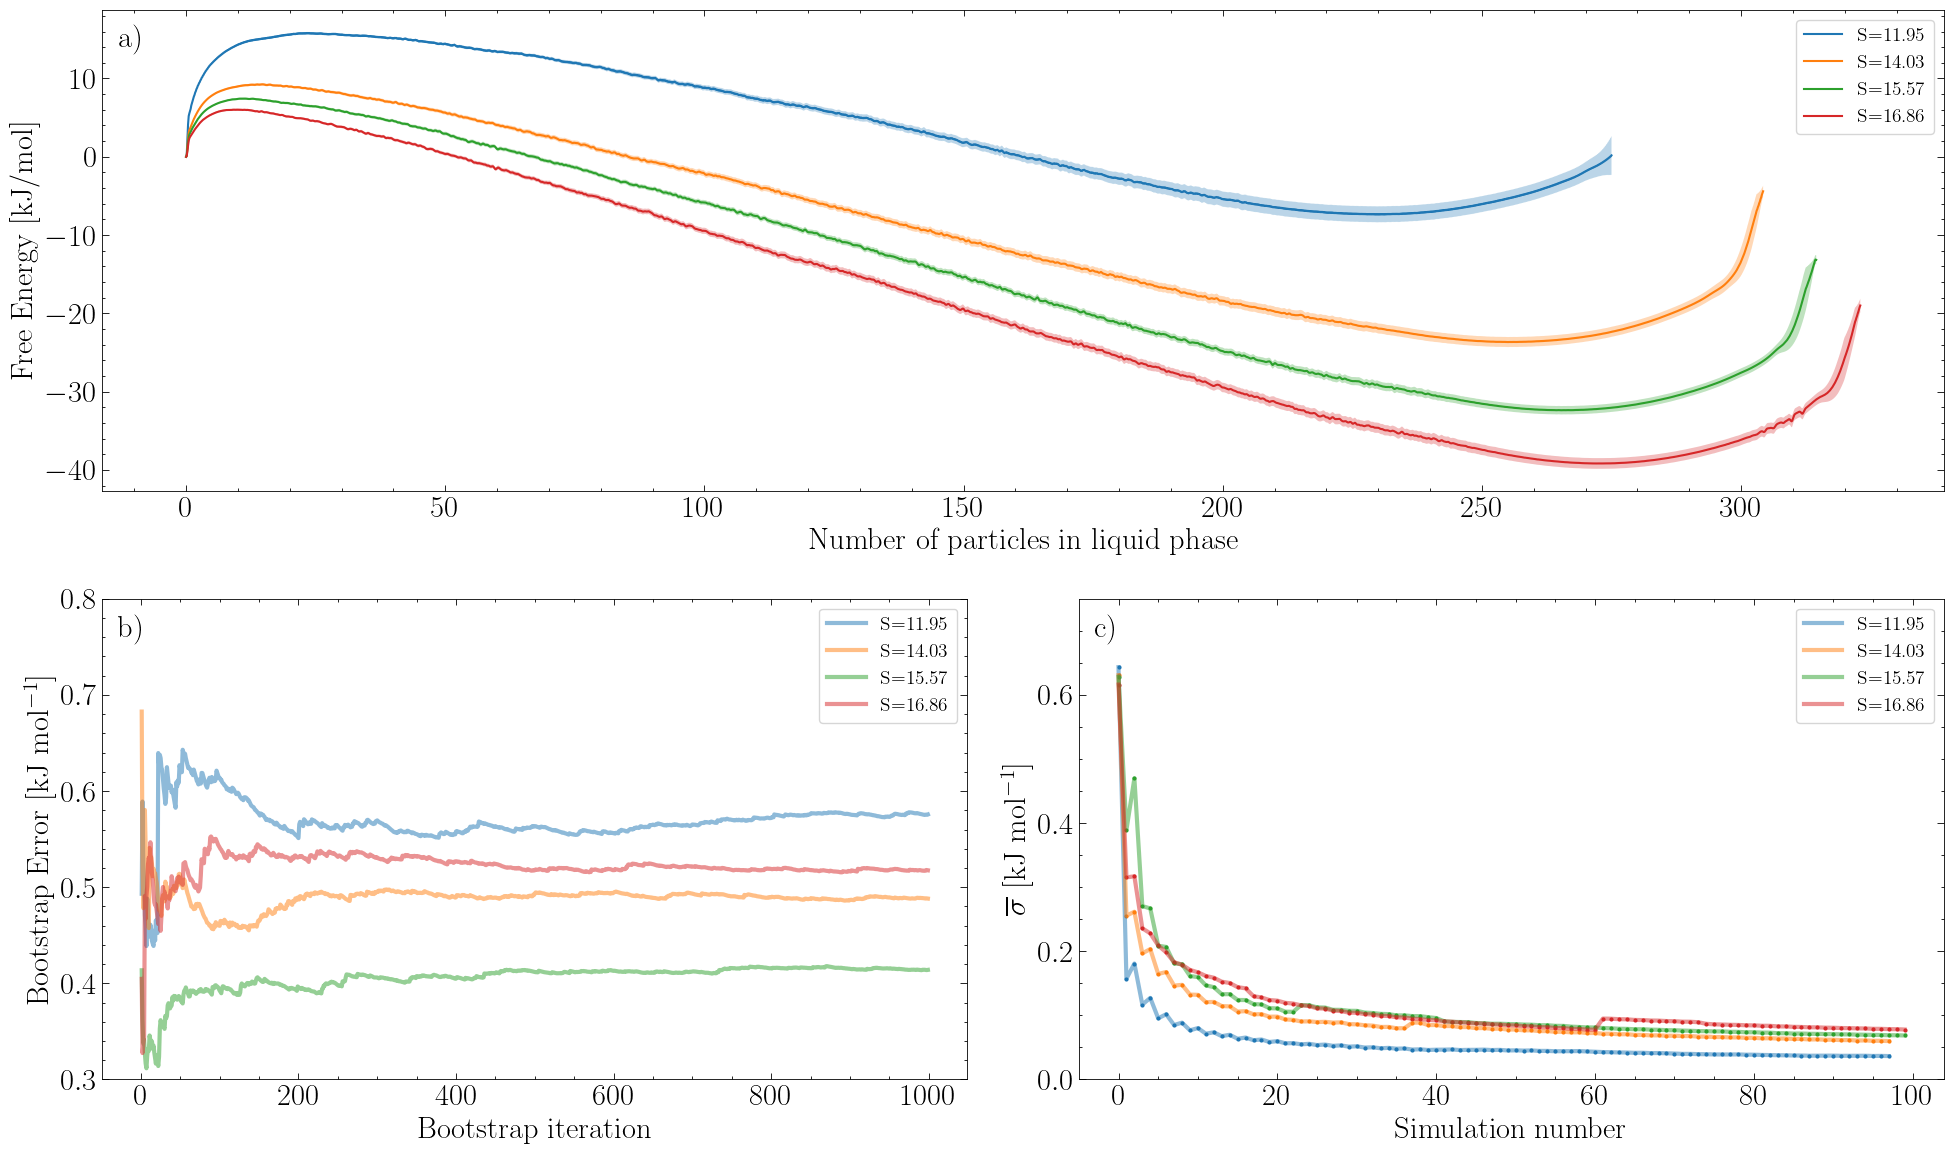

In [6]:
data = MFI1D.load_pkl(path_figure4 + "Figure4_data.pkl")

[[x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0], 
 [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1], 
 [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2], 
 [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3]] = data

name_list = ["55", "65", "73", "80"]
label_list = ["11.95", "14.03", "15.57", "16.86"]
n_bootstrap = 1000
plt.figure(figsize=(20,12)); 

for i in [0,1,2,3]:
    
    if i == 0: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0]
    if i == 1: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1]
    if i == 2: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2]
    if i == 3: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3]
    

    plt.subplot(2,1,1)
    plt.plot(x_plot, FES_plot, label="S=" + label_list[i]);
    plt.fill_between(x_plot, FES_plot - sd_plot, FES_plot + sd_plot, alpha=0.3)

    plt.subplot(2,2,3)
    plt.plot(range(len(sd_fes_prog)), sd_fes_prog, label="S=" + label_list[i],alpha=0.5,linewidth=3)
    # plt.scatter(range(len(sd_fes_prog)), sd_fes_prog, s=4)

    plt.subplot(2,2,4)
    # plt.plot(range(len(Aofe)), Aofe, label="S=" + label_list[i])
    plt.plot(range(len(Aofe)), Aofe, label="S=" + label_list[i],alpha=0.5,linewidth=3)
    plt.scatter(range(len(Aofe)), Aofe, s=4)


plt.subplot(2,1,1); plt.xlabel("Number of particles in liquid phase"), plt.ylabel("Free Energy [kJ/mol]"); plt.legend(fontsize=14); #plt.title("Free Enery Surface with Standard Deviation form Bootstraping ")
# plt.ylim(-5,20);
plt.text(-13,14, "a)")

plt.subplot(2,2,3)
plt.ylim(0.3,0.8); 
plt.xlabel("Bootstrap iteration"), plt.ylabel("Bootstrap Error [kJ mol$^{-1}$]"); plt.legend(fontsize=14); #plt.title("Progression of Standard Deviation by Bootstrap Iteration")
plt.text(-30, 0.76, "b)")

plt.subplot(2,2,4); 
plt.ylim(0, 0.75); 
# plt.xlabel("Simulation number"), plt.ylabel("$\overline{\sigma}_{\frac{dF_t(s)}{ds}}$ [kJ mol$^{-1}$]"); plt.legend(fontsize=14); #plt.title("Progression of the Error of the Mean Force")
plt.xlabel("Simulation number"), plt.ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]"); plt.legend(fontsize=14); #plt.title("Progression of the Error of the Mean Force")
plt.text(-3, 0.69, "c)")


plt.tight_layout()
# plt.savefig(path_manustript + 'Figure4/Figure4_x3.png', dpi=600, bbox_inches='tight')
plt.show()



#### Bootstraping for increasing number of simulations

In [8]:
name_list = ["55", "65", "73", "80"]
label_list = ["11.95", "14.03", "15.57", "18.86"]
grid_list = [np.linspace(0, 275, 2201), np.linspace(0, 310, 2481), np.linspace(0, 315, 2521), np.linspace(0, 330, 2641)]
FES_sd_list = []
plt.figure(figsize=(20,12)); 
max_ofe = 0
min_ofe = 1
max_Aofe = 0
min_Aofe = 1

bootstrap_sd_prog = [[], [], [], []]

n_bootstrap = 200

for i in [0]:#,1,2,3]:

    #load forward and backward forces
    [forceterms_forw, forceterms_back] = MFI1D.load_npy(path_figure4 + "LJ_n" + name_list[i] + "_allforces")

    #Boostrap
    for j in range(2,len(forceterms_forw)):
        print(j, end=" : ")
        [FES_avr, sd_fes, sd_fes_prog ] = MFI1D.bootstrap_forw_back(grid_list[i], np.asarray(forceterms_forw[:j,[0,2],:]), np.asarray(forceterms_back[:j,[0,2],:]), n_bootstrap=n_bootstrap, set_fes_minima="first_value")
        bootstrap_sd_prog[i].append(sd_fes_prog[-1])
    # FES_sd_list.append([FES_avr, sd_fes, sd_fes_prog ])
    
    # MFI.save_pkl(FES_avr, "FES_avr_nb" + str(n_bootstrap) + "_T" + name_list[i])
    
    [x_plot, FES_plot, sd_plot] = remove_flat_tail(grid_list[i], FES_avr, sd_fes)
    
    print("-->max", np.max(sd_fes_prog))
    max_ofe = max(max_ofe, np.nanmax(sd_fes_prog))
    min_ofe = min(min_ofe, np.nanmin(sd_fes_prog))
    
    #calculate ofe error progression of patching
    # all_forces = np.empty((int(len(forceterms_forw)*2), 4, len(grid_list[i])))
    # all_forces[0::2] = forceterms_forw
    # all_forces[1::2] = forceterms_back
    
    all_forces = []
    for j in range(len(forceterms_forw)): 
        all_forces.append(forceterms_back[j])
        all_forces.append(forceterms_forw[j])    
    Ftot_den, Ftot_den2, Ftot, ofv_num, ofe, Aofe = MFI1D.patch_forces_ofe(np.asarray(all_forces), ofe_progression=True, use_weighted_st_dev=False)
    
    max_Aofe = max(max_Aofe, np.max(Aofe))
    min_Aofe = min(min_Aofe, np.min(Aofe))
    
    if i == 0: [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    if i == 1: [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    if i == 2: [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    if i == 3: [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    
# MFI1D.save_pkl([bootstrap_sd_prog, [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0], [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1], [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2], [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3]], path_figure4 + "Figure4_data_err_vs_nsim.pkl")

2 : Iteration: 50 - sd: 0.0
Iteration: 100 - sd: 0.0
Iteration: 150 - sd: 0.0
Iteration: 200 - sd: 0.0
3 : Iteration: 50 - sd: 0.95596
Iteration: 100 - sd: 0.91746
Iteration: 150 - sd: 0.94174
Iteration: 200 - sd: 0.91005
4 : Iteration: 50 - sd: 0.89494
Iteration: 100 - sd: 0.83475
Iteration: 150 - sd: 0.86869
Iteration: 200 - sd: 0.84906
5 : Iteration: 50 - sd: 0.88934
Iteration: 100 - sd: 0.88095
Iteration: 150 - sd: 0.90238
Iteration: 200 - sd: 0.89625
6 : Iteration: 50 - sd: 0.96042
Iteration: 100 - sd: 0.96091
Iteration: 150 - sd: 0.94895
Iteration: 200 - sd: 0.95675
7 : Iteration: 50 - sd: 0.86309
Iteration: 100 - sd: 0.88662
Iteration: 150 - sd: 0.90015
Iteration: 200 - sd: 0.86994
8 : Iteration: 50 - sd: 0.72566
Iteration: 100 - sd: 0.76298
Iteration: 150 - sd: 0.75315
Iteration: 200 - sd: 0.75191
9 : Iteration: 50 - sd: 0.72014
Iteration: 100 - sd: 0.72385
Iteration: 150 - sd: 0.7251
Iteration: 200 - sd: 0.71639
10 : Iteration: 50 - sd: 0.72332
Iteration: 100 - sd: 0.69508
Ite

<Figure size 2000x1200 with 0 Axes>

47
47
48
48


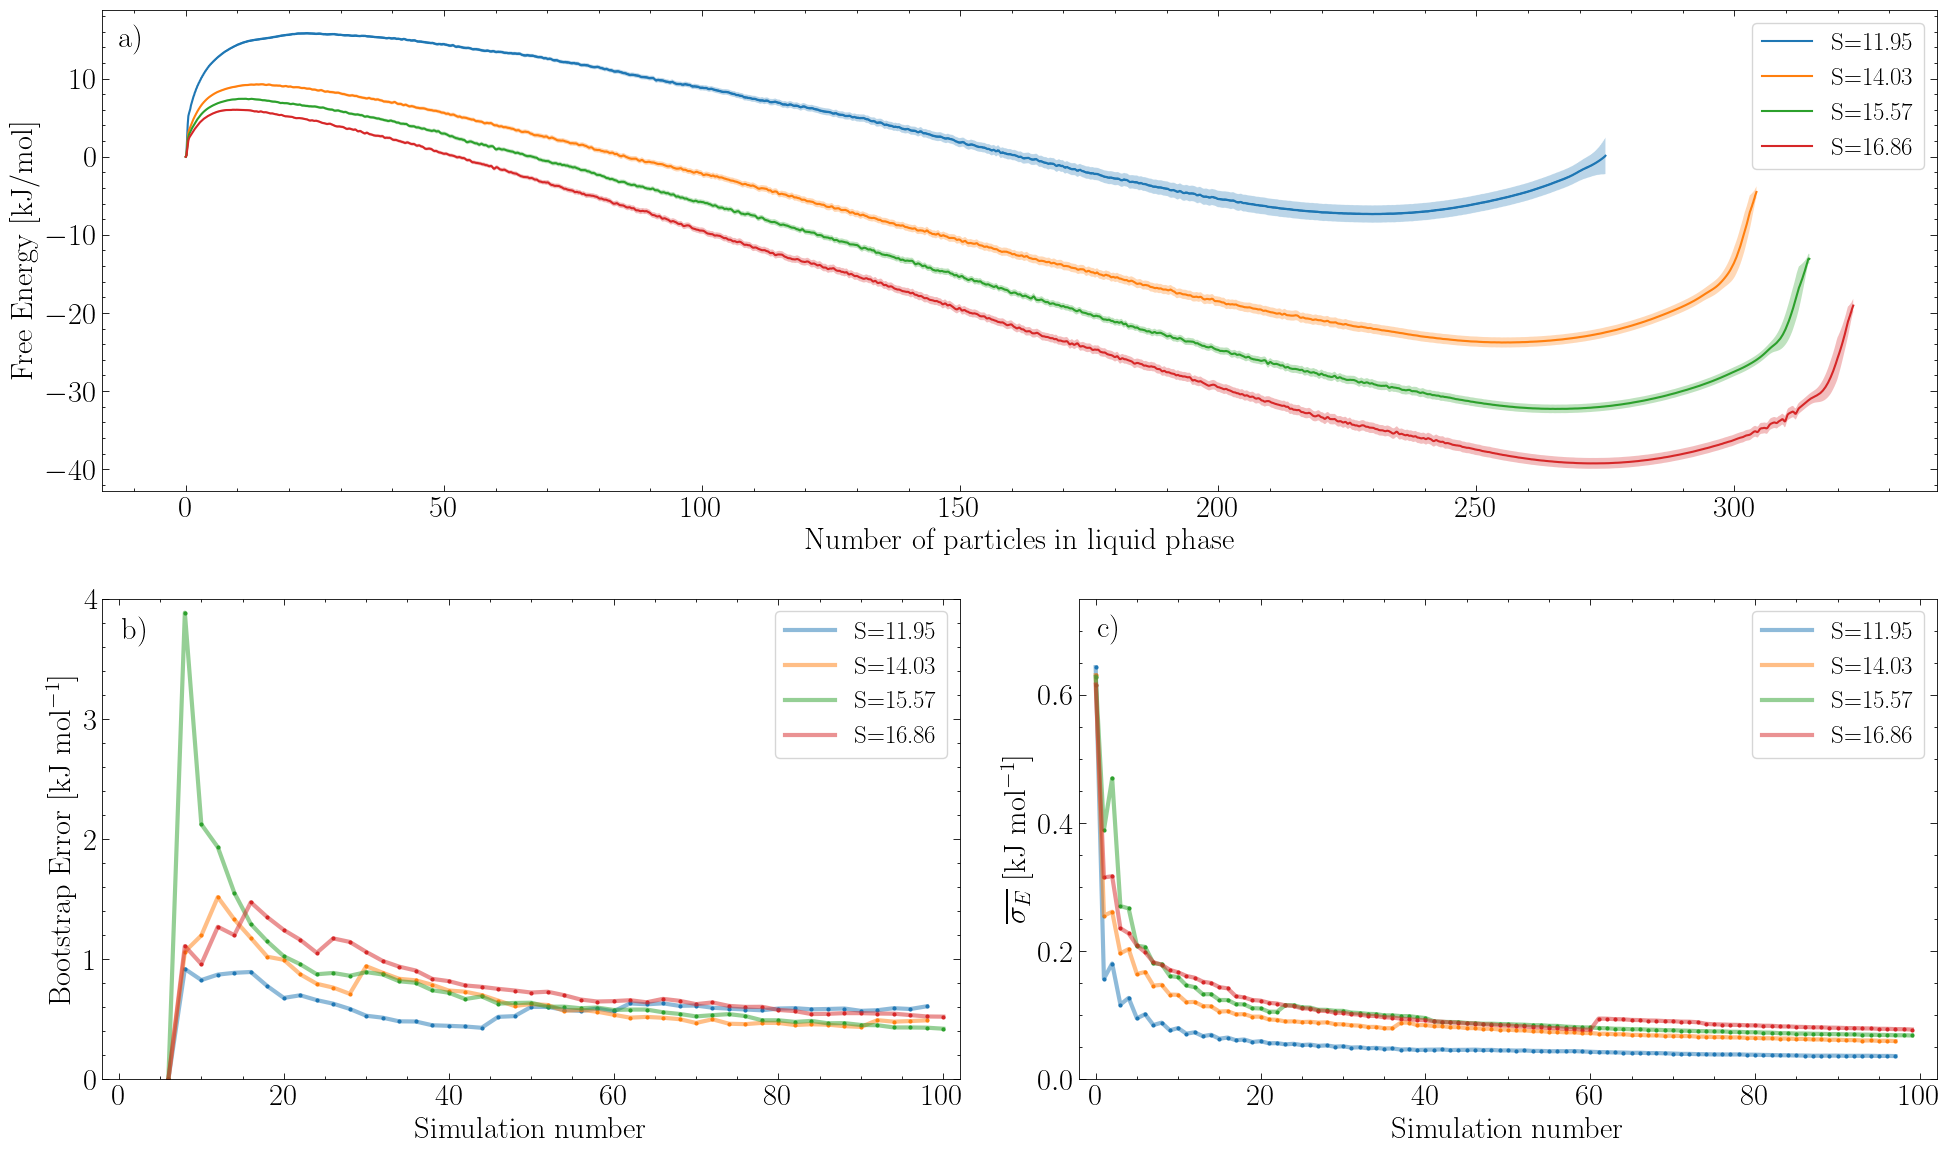

In [9]:
# data = MFI1D.load_pkl(path_figure4 + "Figure4_data.pkl")
data = MFI1D.load_pkl(path_figure4 + "Figure4_data_err_vs_nsim.pkl")

[bootstrap_sd_prog, 
 [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0], 
 [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1], 
 [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2], 
 [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3]] = data

name_list = ["55", "65", "73", "80"]
label_list = ["11.95", "14.03", "15.57", "16.86"]
n_bootstrap = 1000
plt.figure(figsize=(20,12)); 

for i in [0,1,2,3]:
    
    if i == 0: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0]
    if i == 1: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1]
    if i == 2: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2]
    if i == 3: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3]
    
    print(len(bootstrap_sd_prog[i]))

    plt.subplot(2,1,1)
    plt.plot(x_plot, FES_plot, label="S=" + label_list[i]);
    plt.fill_between(x_plot, FES_plot - sd_plot, FES_plot + sd_plot, alpha=0.3)

    plt.subplot(2,2,3)
    # plt.plot(range(len(sd_fes_prog)), sd_fes_prog, label="S=" + label_list[i],alpha=0.5,linewidth=3)
    plt.plot([e*2 for e in range(3, len(bootstrap_sd_prog[i])+3)], bootstrap_sd_prog[i], label="S=" + label_list[i],alpha=0.5,linewidth=3)
    plt.scatter([e*2 for e in range(3, len(bootstrap_sd_prog[i])+3)], bootstrap_sd_prog[i], s=4)
    # plt.scatter(range(len(sd_fes_prog)), sd_fes_prog, s=4)

    plt.subplot(2,2,4)
    # plt.plot(range(len(Aofe)), Aofe, label="S=" + label_list[i])
    plt.plot(range(len(Aofe)), Aofe, label="S=" + label_list[i],alpha=0.5,linewidth=3)
    plt.scatter(range(len(Aofe)), Aofe, s=4)


plt.subplot(2,1,1); plt.xlabel("Number of particles in liquid phase"), plt.ylabel("Free Energy [kJ/mol]"); plt.legend(fontsize=18); #plt.title("Free Enery Surface with Standard Deviation form Bootstraping ")
# plt.ylim(-5,20);
plt.text(-13,14, "a)")

plt.subplot(2,2,3)
plt.ylim(0,4); 
plt.xlim(-2,102)
plt.xlabel("Simulation number"), plt.ylabel("Bootstrap Error [kJ mol$^{-1}$]"); plt.legend(fontsize=18); #plt.title("Progression of Standard Deviation by Bootstrap Iteration")
plt.text(0.3, 3.66, "b)")

plt.subplot(2,2,4); 
plt.ylim(0, 0.75); 
plt.xlim(-2,102)
plt.xlabel("Simulation number"), plt.ylabel("$\overline{\sigma_E}$ [kJ mol$^{-1}$]"); plt.legend(fontsize=18); #plt.title("Progression of the Error of the Mean Force")
plt.text(0.3, 0.69, "c)")


plt.tight_layout()
plt.savefig(path_manustript + 'Figure4/Figure4_new.png', dpi=600, bbox_inches='tight')
plt.show()



#### Compare ofe vs aad

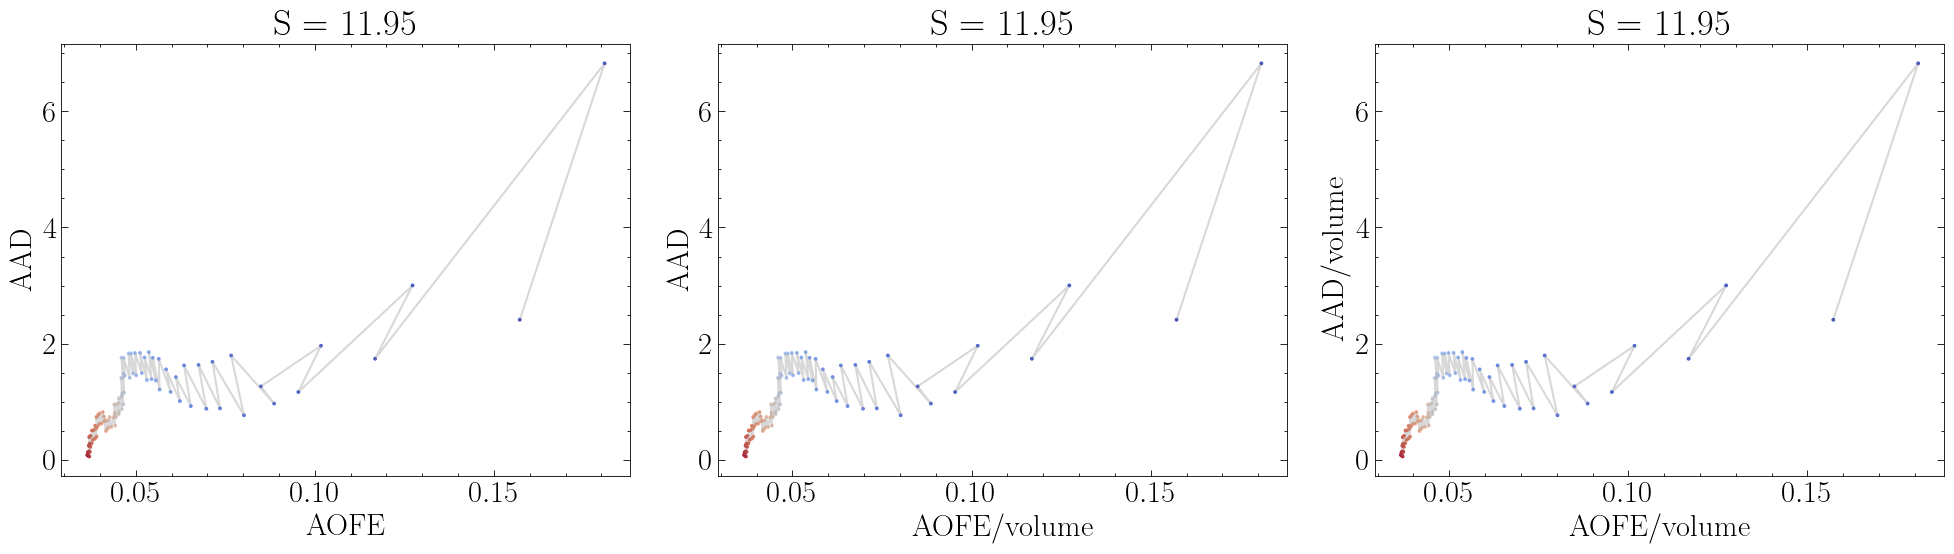

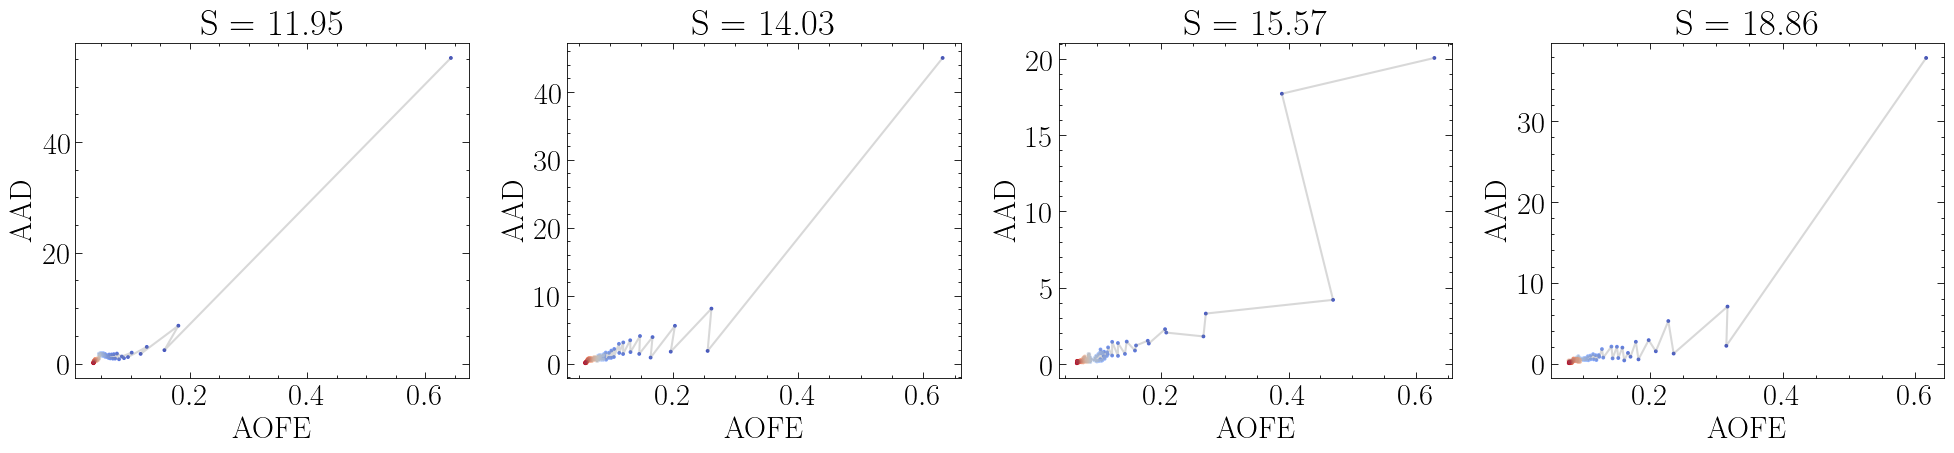

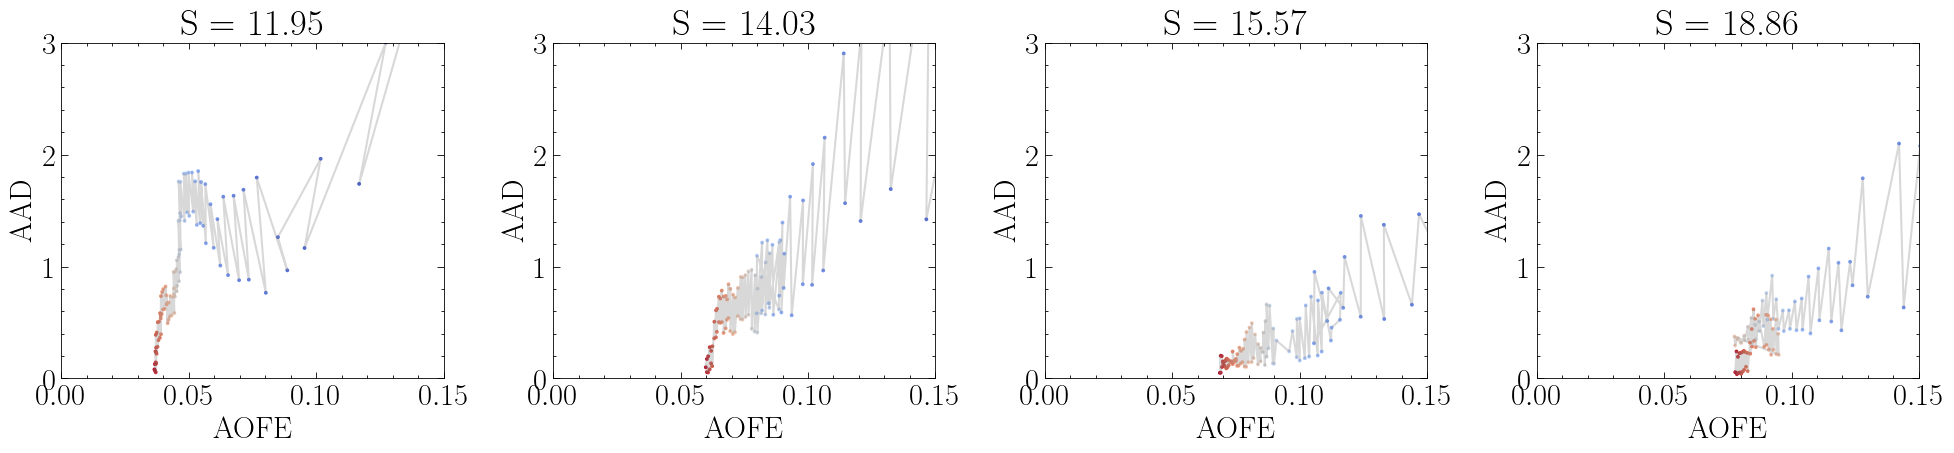

In [10]:
name_list = ["55", "65", "73", "80"]
label_list = ["11.95", "14.03", "15.57", "18.86"]
grid_list = [np.linspace(0, 275, 2201), np.linspace(0, 310, 2481), np.linspace(0, 315, 2521), np.linspace(0, 330, 2641)]
FES_sd_list = []
max_ofe = 0
min_ofe = 1
max_Aofe = 0
min_Aofe = 1

# plt.figure(figsize=(20,5))
cmap = plt.cm.get_cmap('coolwarm')

for i in [0,1,2,3]:
    #load forward and backward forces
    [forceterms_forw, forceterms_back] = MFI1D.load_npy(path_figure4 + "LJ_n" + name_list[i] + "_allforces")
    #Load fererence fes
    FES_ref = MFI1D.load_pkl(path_figure4 + "FES_avr_nb1000_T" + name_list[i])

    all_forces = []
    for j in range(len(forceterms_forw)): 
        all_forces.append(forceterms_back[j])
        all_forces.append(forceterms_forw[j])    
    PD_patch, PD2_patch, F_patch, OFV_num_patch, FES, AD, AAD, OFE, AOFE, volume = MFI1D.patch_forces_ofe_AD(np.asarray(all_forces), grid=grid_list[i], y=FES_ref, error_progression=True, use_weighted_st_dev=False, set_fes_minima="first")

    if i == 0:
        plt.figure(1,figsize=(20,6)); 
        norm = plt.Normalize(0, len(AOFE[1:])) 
        
        plt.subplot(1,3,1)
        plt.scatter(AOFE[1:], AAD[1:] ,s=3, c=range(len(AOFE[1:])), cmap=cmap, norm=norm)
        plt.plot(AOFE[1:], AAD[1:] , c="grey", alpha=0.3); 
        plt.ylabel("AAD"); plt.xlabel("AOFE"); plt.title("S = " + label_list[i])

        plt.subplot(1,3,2)
        plt.scatter(AOFE[1:]/volume[1:], AAD[1:] ,s=3, c=range(len(AOFE[1:])), cmap=cmap, norm=norm)
        plt.plot(AOFE[1:]/volume[1:], AAD[1:] , c="grey", alpha=0.3); 
        plt.ylabel("AAD"); plt.xlabel("AOFE/volume"); plt.title("S = " + label_list[i])
        
        plt.subplot(1,3,3)
        plt.scatter(AOFE[1:]/volume[1:], AAD[1:]/volume[1:] ,s=3, c=range(len(AOFE[1:])), cmap=cmap, norm=norm)
        plt.plot(AOFE[1:]/volume[1:], AAD[1:]/volume[1:] , c="grey", alpha=0.3); 
        plt.ylabel("AAD/volume"); plt.xlabel("AOFE/volume"); plt.title("S = " + label_list[i])
        plt.tight_layout(); plt.show()

    plt.figure(2,figsize=(20,5))
    plt.subplot(1,4,i+1)
    norm = plt.Normalize(0, len(AOFE)) 
    plt.scatter(AOFE, AAD ,s=3, c=range(len(AOFE)), cmap=cmap, norm=norm)
    plt.plot(AOFE, AAD , c="grey", alpha=0.3); 
    plt.ylabel("AAD"); plt.xlabel("AOFE"); plt.title("S = " + label_list[i]); plt.tight_layout()
    
    plt.figure(3,figsize=(20,5))
    plt.subplot(1,4,i+1)
    norm = plt.Normalize(0, len(AOFE)) 
    plt.scatter(AOFE, AAD ,s=3, c=range(len(AOFE)), cmap=cmap, norm=norm)
    plt.plot(AOFE, AAD , c="grey", alpha=0.3); 
    plt.ylabel("AAD"); plt.xlabel("AOFE"); plt.title("S = " + label_list[i]); plt.xlim(0,0.15); plt.ylim(0,3); plt.tight_layout()

# plt.figure(2,figsize=(20,5)); plt.tight_layout()
# plt.figure(1,figsize=(20,5)); plt.tight_layout()
plt.show()